In [1]:
# # get hazard object
# import numpy as np
# from climada.hazard import Hazard, Centroids
# from climada.test import get_test_file

# haz_tc_fl = Hazard.from_hdf5(
#     get_test_file("HAZ_DEMO_FL_15")
# )
# haz_tc_fl.check()



In [2]:
import warnings

warnings.filterwarnings("ignore")

from climada.entity import ImpactFuncSet, ImpfTropCyclone
from climada.engine import ImpactCalc
from climada.util.api_client import Client
from climada.util.constants import CMAP_IMPACT
from climada.util.plot import plot_from_gdf
import numpy as np

client = Client()
haz_tc_haiti = client.get_hazard(
    "tropical_cyclone",
    properties={
        "country_name": "Haiti",
        "climate_scenario": "historical",
        "nb_synth_tracks": "10",
    },
)
haz_tc_haiti.check()

In [3]:
# prepare exposure
from climada.util.api_client import Client
client = Client()


exposure = client.get_litpop(country="Haiti")
exposure.check()

In [4]:
# prepare impact function

impf_tc = ImpfTropCyclone.from_emanuel_usa()
impf_set = ImpactFuncSet([impf_tc])
impf_set.check()

In [5]:
# compute impact

impact = ImpactCalc(exposure, impf_set, haz_tc_haiti).impact(save_mat=True)

In [6]:
np.unique(1/haz_tc_haiti.frequency/11, return_counts=True)

(array([ 8., 31., 41.]), array([   33,  2893, 40634]))

In [7]:
# compute local exceedance instensity
test_return_periods = np.geomspace(.01, 341, 100)
local_exceedance_intensity, label, title = impact.local_exceedance_impact(
    return_periods=test_return_periods#, method="extrapolate_constant"#method="extrapolate" method="extrapolate_constant"
)

In [8]:
from return_period_maps import ReturnPeriodMap, ExceedanceCurve
rp_map = ReturnPeriodMap.from_CLIMADA_local_exceedance_intensity(local_exceedance_intensity)

<Axes: >

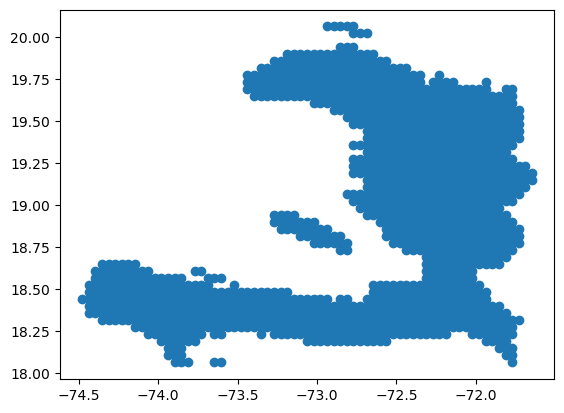

In [9]:
rp_map.geometry.plot()

In [10]:
from coordinates import change_grid_resolution

change_grid_resolution(rp_map.geometry, 2)[0]


0      POINT (-74.45833 18.08333)
1      POINT (-74.45833 18.16667)
2      POINT (-74.45833 18.25000)
3      POINT (-74.45833 18.33333)
4      POINT (-74.45833 18.41667)
                  ...            
811    POINT (-71.70833 19.66667)
812    POINT (-71.70833 19.75000)
813    POINT (-71.70833 19.83333)
814    POINT (-71.70833 19.91667)
815    POINT (-71.70833 20.00000)
Length: 816, dtype: geometry

In [11]:
rp_map.compute_aai_aggregated()

186437472.0788105

In [ ]:
rp_map.compute_aai_per_centroid()

array([3558.06383342, 3792.77971862,  990.38313122, ...,  748.91389327,
       1364.45050907, 1337.42391777])

: 

In [ ]:
rp_map_half = rp_map.coarsen(scale_factor=2)

centroid 3
exfreq shape (1, 100)
0.0002443494184541928
centroid 4
exfreq shape (3, 100)
0.0002443494184541928
final values shape (101,)
aggregate
aggregate complete
0.0 367580.99293127516 50.0
combined probs (1203,)
combined probs to final array (7352,)
7000
final values reshaped (353,)
final values shape (353,)
aggregate
aggregate complete
0.0 1348213840.4964657 50.0


In [ ]:
np.diff(np.unique(all_coords[:,1]))

In [ ]:
print(impact.aai_agg/1000000)

In [ ]:
rp_map.compute_aai_aggregated()/1000000

In [ ]:
np.sum(impact.frequency)

In [ ]:
max_inds = [0, 1227, 1278, 1222] #[0,1227, 1278, 1277]
# max_inds = [1278] 
c_frac = 1/10000

from exceedance_curves import combine_exceedance_curves
agg_rp_curve = combine_exceedance_curves(
    [rp_map.exceedance_curves[i] for i in max_inds],
    value_resolution=10.,
    aggregation_method=sum,
    coincidence_fraction=c_frac)

summation = 0
for i in max_inds:
    summation += rp_map.exceedance_curves[i].average_annual_impact()
print(summation)
print(agg_rp_curve.average_annual_impact())

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for i in max_inds:
    ax.plot(1/rp_map.exceedance_curves[i].exceedance_frequencies, rp_map.exceedance_curves[i].values)

ax.plot(1/agg_rp_curve.exceedance_frequencies, agg_rp_curve.values, label='aggregated')
ax.plot(1/rp_map.exceedance_curves[0].exceedance_frequencies, np.sum([rp_map.exceedance_curves[i].values for i in max_inds], axis=0), label='sum')
ax.legend()
ax.set_xlim(.5, 20);

In [ ]:
from utils import frequency_from_exceedance_frequency, prob_from_exceedance_frequency
summation = 0
for i in max_inds:
    summation += rp_map.exceedance_curves[i].average_annual_impact()
print(summation)
print(agg_rp_curve.average_annual_impact()
indices_initial = np.where(
    (agg_rp_curve.exceedance_frequencies >= 1/15) &
    (agg_rp_curve.exceedance_frequencies <= 1/1)
    )
ex_freq = agg_rp_curve.exceedance_frequencies[indices_initial]
vals = agg_rp_curve.values[indices_initial]

print(np.nansum(vals * prob_from_exceedance_frequency(ex_freq, coincidence_fraction=1)[1:]))
           


## Test Carmen RP curves

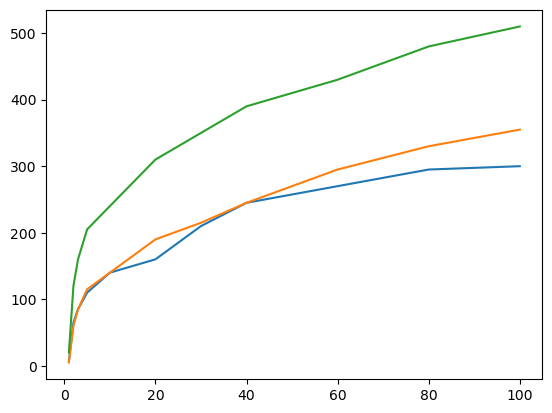

In [20]:
import numpy as np
import matplotlib.pyplot as plt
# rps_carmen = np.geomspace(1, 500, 50)
# exf_carmen = 1/rps_carmen
# values_carmen = 25*np.log(rps_carmen)
rps_carmen = np.array([1, 2, 3, 5, 10, 20, 30, 40, 60, 80, 100])
exf_carmen = 1/rps_carmen
# values_carmen = 25*np.log(rps_carmen)
values_carmen_TC = np.array([5, 60, 85, 115, 140, 190, 215, 245, 295, 330, 355])
values_carmen_RF = np.array([7, 65, 85, 110, 140, 160, 210, 245, 270, 295, 300])
values_carmen_combined = np.array([20, 120, 160, 205, 240, 310, 350, 390, 430, 480, 510])
plt.plot(rps_carmen, values_carmen_RF)
plt.plot(rps_carmen, values_carmen_TC)
plt.plot(rps_carmen, values_carmen_combined)



In [15]:
from return_period_maps import ReturnPeriodMap, ExceedanceCurve
from exceedance_curves import ExceedanceCurve, combine_exceedance_curves

exceedance_curves_carmen = [ExceedanceCurve(
    values=vals,
    exceedance_frequencies=exf_carmen,
) for vals in [values_carmen_RF, values_carmen_TC]] # left plot
# ) for fac in [25, 70]] # right plot

(-20.0, 570.0)

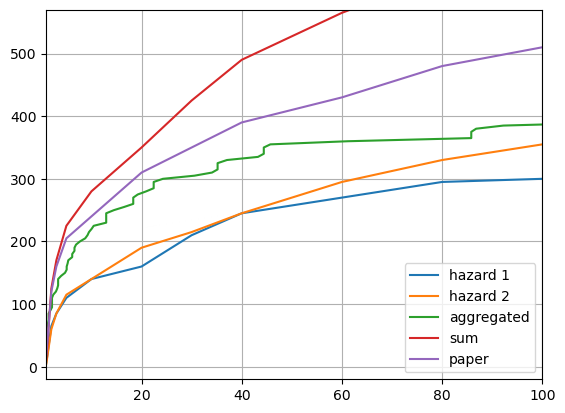

In [26]:
agg_curve_carmen = combine_exceedance_curves(
    exceedance_curves_carmen,
    value_resolution=5.,
    aggregation_method=sum,
    coincidence_fraction=1)

fig, ax = plt.subplots()
for i in [0,1]:
    ax.plot(1/exceedance_curves_carmen[i].exceedance_frequencies, exceedance_curves_carmen[i].values, label=f'hazard {i+1}')


ax.plot(1/agg_curve_carmen.exceedance_frequencies, agg_curve_carmen.values, label='aggregated')
ax.plot(1/exceedance_curves_carmen[0].exceedance_frequencies, np.sum([exceedance_curves_carmen[i].values for i in [0,1]], axis=0), label='sum')
ax.plot(1/exceedance_curves_carmen[0].exceedance_frequencies, values_carmen_combined, label='paper')

ax.grid()
ax.legend()
ax.set_xlim(1, 100)
ax.set_ylim(-20, 570)

In [ ]:
exceedance_curves_carmen[0].exceedance_frequencies

array([1.        , 0.59948425, 0.35938137, 0.21544347, 0.12915497,
       0.07742637, 0.04641589, 0.02782559, 0.01668101, 0.01      ])

In [ ]:
efs = rp_map.exceedance_curves[0].exceedance_frequencies
vals = rp_map.exceedance_curves[0].values

In [3]:
rps_carmen = np.geomspace(.1, 10000, 10)
exf_carmen = 1/rps_carmen
# values_carmen = 25*np.log(rps_carmen)+60
values_carmen = 25*np.power(rps_carmen, .25)

cfrac = np.linspace(.01,1,100)
# aai = [np.nansum(vals * prob_from_exceedance_frequency(efs, coincidence_fraction=cfra)[1:])/cfra
aai = [np.nansum(values_carmen * prob_from_exceedance_frequency(exf_carmen, coincidence_fraction=cfra)[1:])/cfra

       for cfra in cfrac]

plt.plot(cfrac, aai)

NameError: name 'prob_from_exceedance_frequency' is not defined

In [ ]:
prob_from_exceedance_frequency(exf_carmen, coincidence_fraction=1)[0:]

In [ ]:
print(prob_from_exceedance_frequency(exf_carmen, coincidence_fraction=1)[0]/1)
print(prob_from_exceedance_frequency(exf_carmen, coincidence_fraction=1/12)[0])

In [ ]:
prob_from_exceedance_frequency(exf_carmen, coincidence_fraction=1/12)[0]

In [ ]:
values_carmen

In [ ]:
np.exp(-exf_carmen[0]/12)

In [ ]:
ef = np.array([.01, .05, .08, .1, .11])

In [ ]:
np.cumsum(prob_from_exceedance_frequency(ef[::-1], coincidence_fraction=1)[::-1])